According to main_train_pt.py example result as below:

# PROCESSES

In [1]:
from utils.nn_pt_utils import TorchClassifierWrapper, saved_model_usage
from utils.ml_utils import re_sample, pre_model
from utils.prepropcessing_utils import plot_category
from collections import Counter
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


# =======================================  PREPARE DATA  ================================================
def handling_data_pt(path=1, plot=False):
        path1 = 'data/PTT_BK_usage.csv'
        path2 = 'data/PTT_BK_usage2.csv'

        if path == 1:
            df = pd.read_csv(path1)
            df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
            df.dropna(inplace=True)
            df = df.reset_index(drop=True)
        elif path == 2:
            df = pd.read_csv(path2)
            drop_cols = ['Date','target','future_return_5','rsi_result', 'macd_result', 'bb_result', 'adx_result']
            df = df.drop(columns=drop_cols).dropna()

            df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
            df.dropna(inplace=True)
            df = df.reset_index(drop=True)
        else:
             raise "********** PATH INVALID **************"

        # features = ['Low','SMA_5', 'rsi', 'macd_diff',  'adx', 'target_encoded']
        # df = df[features]
        # print(df.head(5))
        print(Counter(df['target_encoded']))
        print(f'Shape of data: {df.shape}')
        print(df.columns)

        df_balanced = re_sample(df, y_col='target_encoded')


        if plot: 
            plot_category('target_encoded', df_balanced)

        X, y, preprocessor = pre_model(df_balanced)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

        # classifier_main_xgb(X_train, X_test, y_train, y_test, preprocessor=preprocessor)

        return X_train, X_test, y_train, y_test, preprocessor

# =======================================  PROCESSE1: TRAINING  ================================================
# Train the model
def train_model(X_train, y_train, preprocessor, get_prediction=False, plot=False):

    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', TorchClassifierWrapper(hidden_dim=128, output_dim=3,  # number feature input
                                         epochs=100, lr=0.001, criteria='cross-ent',
                                         batch_size=16, val_size=0.1, patience=15, debug=False))       # number feature input
    ])

    pipeline.fit(X_train, y_train)
    print("\nModel training complete..........")

    # Get feature names after transformation
    feature_names = preprocessor.get_feature_names_out()
    print("Feature names after preprocessing:", feature_names)


    # Get predictions
    if get_prediction:
        print("\nModel get prediction..........")
        x = X_train[500:505]
        predictions = pipeline.predict(x)
        print(predictions)

    # plot performances
    if plot :
        print("\nModel plot..........")
        pipeline.named_steps['model'].plot_performance()

    return pipeline
# =======================================  PROCESSE2: EVALUATION ================================================
# Evaluation part
def evaluate_model(pipeline, X_test, y_test, X_train, y_train, cv=False):
    print("\nModel evaluation..........")

    # Cross-validation scores while training
    if cv == True:
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        print("Cross-validation scores:", scores)
        print("Average CV accuracy:", scores.mean())

    # Evaluate the Model with test set
    report, acc, precision, recall, f1, cm, cm_display = pipeline.score(X_test, y_test)
    print(report)
    print('Confusion matrix:')
    print(cm)


# =======================================  PROCESSE3: SAVE MODEL ================================================
# Saved relevant files
def save_model(pipeline, label_encoder=None):
    model_name = "ANN_pt"
    # Save the model pipeline> model> model(keras)
    pipeline.named_steps['model'].save_model(model_name)

    # Save the preprocessor
    preprocess = pipeline.named_steps['preprocess']
    joblib.dump(preprocess, f'model/{model_name}_preprocessor.pkl')

    # Save the LabelEncoder
    if label_encoder:
        joblib.dump(label_encoder, f'model/{model_name}_label_encoder.pkl')

    # 

# =======================================  PROCESSE4: GET PREDICTION ================================================
# Make Predictions and usage model:
def use_model(X):
    path_model = "model/ANN_pt_complete.pth"
    path_his = "model/ANN_pt_history.pth"
    path_pre = "model/ANN_pt_preprocessor.pkl"
    # path_label = "model/ANN_pt_label_encoder.pkl"

    saved_model = saved_model_usage(path_model=path_model, path_his=path_his, path_pre=path_pre)
    model, history = saved_model.load_model()
    # saved_model.plot_saved_history()    # plot model

    # Get predictions
    print("\nModel get prediction..........")
    x = X[10:15]

    predictions = saved_model.get_prediction(x)

    return predictions


 ## STEP1: PREPARE DATA

In [2]:
# STEP1: prepare data
X_train, X_test, y_train, y_test, preprocessor = handling_data_pt(path=2, plot=False)

Counter({1: 3531, 0: 1370, 2: 793})
Shape of data: (5694, 30)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sqrt_Volume', 'Close_t-1',
       'Close_t-2', 'Volume_t-1', 'SMA_5', 'STD_5', 'EMV_5', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_upper', 'bb_lower', 'bb_width', 'adx',
       'adx_pos', 'adx_neg', 'Daily_Return', 'Close_Diff_t-1', 'Year',
       'Quarter', 'Day', 'Month', 'Weekday', 'target_encoded'],
      dtype='object')


## STEP2: TRAINING
   

In [ ]:
# STEP2: traning
pipepline = train_model(X_train, y_train, preprocessor,get_prediction=True, plot=False)

<pre> 
    fiting process.....................................

    Initial load data....
    Unique labels in full y: [0 1 2]

    Start training data....
    Training for 100 epochs with batch size 16...

    Epoch 1/100, Train Loss: 0.8648, Train Acc: 0.5616, Val Loss: 0.7614, Val Acc: 0.6050
    Epoch 2/100, Train Loss: 0.7854, Train Acc: 0.6122, Val Loss: 0.7025, Val Acc: 0.6651
    Epoch 3/100, Train Loss: 0.7627, Train Acc: 0.6226, Val Loss: 0.6687, Val Acc: 0.6722
    Epoch 4/100, Train Loss: 0.7405, Train Acc: 0.6335, Val Loss: 0.7045, Val Acc: 0.6698
    Epoch 5/100, Train Loss: 0.7249, Train Acc: 0.6482, Val Loss: 0.6918, Val Acc: 0.6863
    Epoch 6/100, Train Loss: 0.7171, Train Acc: 0.6530, Val Loss: 0.6213, Val Acc: 0.6981
    Epoch 7/100, Train Loss: 0.7061, Train Acc: 0.6614, Val Loss: 0.5906, Val Acc: 0.7524
    Epoch 8/100, Train Loss: 0.6912, Train Acc: 0.6740, Val Loss: 0.6089, Val Acc: 0.7300
    Epoch 9/100, Train Loss: 0.6867, Train Acc: 0.6686, Val Loss: 0.5905, Val Acc: 0.7241
    Epoch 10/100, Train Loss: 0.6807, Train Acc: 0.6799, Val Loss: 0.6007, Val Acc: 0.7512
    Epoch 11/100, Train Loss: 0.6638, Train Acc: 0.6819, Val Loss: 0.5919, Val Acc: 0.7335
    Epoch 12/100, Train Loss: 0.6451, Train Acc: 0.7012, Val Loss: 0.6013, Val Acc: 0.7347
    Epoch 13/100, Train Loss: 0.6362, Train Acc: 0.7073, Val Loss: 0.5757, Val Acc: 0.7417
    Epoch 14/100, Train Loss: 0.6302, Train Acc: 0.7023, Val Loss: 0.5851, Val Acc: 0.7146
    Epoch 15/100, Train Loss: 0.6337, Train Acc: 0.7042, Val Loss: 0.5612, Val Acc: 0.7335
    Epoch 16/100, Train Loss: 0.6311, Train Acc: 0.7082, Val Loss: 0.5664, Val Acc: 0.7488
    Epoch 17/100, Train Loss: 0.6113, Train Acc: 0.7263, Val Loss: 0.5382, Val Acc: 0.7807
    Epoch 18/100, Train Loss: 0.6121, Train Acc: 0.7216, Val Loss: 0.5560, Val Acc: 0.7748
    Epoch 19/100, Train Loss: 0.5986, Train Acc: 0.7244, Val Loss: 0.5191, Val Acc: 0.7889
    Epoch 20/100, Train Loss: 0.5906, Train Acc: 0.7318, Val Loss: 0.5128, Val Acc: 0.7748
    Epoch 21/100, Train Loss: 0.5852, Train Acc: 0.7317, Val Loss: 0.5264, Val Acc: 0.7665
    Epoch 22/100, Train Loss: 0.5736, Train Acc: 0.7465, Val Loss: 0.5168, Val Acc: 0.7736
    Epoch 23/100, Train Loss: 0.5808, Train Acc: 0.7377, Val Loss: 0.5327, Val Acc: 0.7724
    Epoch 24/100, Train Loss: 0.5643, Train Acc: 0.7535, Val Loss: 0.5162, Val Acc: 0.7889
    Epoch 25/100, Train Loss: 0.5622, Train Acc: 0.7455, Val Loss: 0.5159, Val Acc: 0.7866
    Epoch 26/100, Train Loss: 0.5596, Train Acc: 0.7491, Val Loss: 0.4786, Val Acc: 0.7995
    Epoch 27/100, Train Loss: 0.5579, Train Acc: 0.7527, Val Loss: 0.4999, Val Acc: 0.7818
    Epoch 28/100, Train Loss: 0.5576, Train Acc: 0.7545, Val Loss: 0.4951, Val Acc: 0.7807
    Epoch 29/100, Train Loss: 0.5478, Train Acc: 0.7547, Val Loss: 0.4919, Val Acc: 0.7795
    Epoch 30/100, Train Loss: 0.5332, Train Acc: 0.7665, Val Loss: 0.4911, Val Acc: 0.7889
    Epoch 31/100, Train Loss: 0.5350, Train Acc: 0.7628, Val Loss: 0.4971, Val Acc: 0.7736
    Epoch 32/100, Train Loss: 0.5256, Train Acc: 0.7700, Val Loss: 0.4719, Val Acc: 0.8007
    Epoch 33/100, Train Loss: 0.5228, Train Acc: 0.7762, Val Loss: 0.4853, Val Acc: 0.7960
    Epoch 34/100, Train Loss: 0.5111, Train Acc: 0.7758, Val Loss: 0.4775, Val Acc: 0.8042
    Epoch 35/100, Train Loss: 0.5119, Train Acc: 0.7746, Val Loss: 0.4733, Val Acc: 0.8019
    Epoch 36/100, Train Loss: 0.5030, Train Acc: 0.7766, Val Loss: 0.4488, Val Acc: 0.8208
    Epoch 37/100, Train Loss: 0.5078, Train Acc: 0.7766, Val Loss: 0.4764, Val Acc: 0.8113
    Epoch 38/100, Train Loss: 0.5015, Train Acc: 0.7839, Val Loss: 0.4643, Val Acc: 0.8031
    Epoch 39/100, Train Loss: 0.5012, Train Acc: 0.7851, Val Loss: 0.4578, Val Acc: 0.8196
    Epoch 40/100, Train Loss: 0.4914, Train Acc: 0.7936, Val Loss: 0.4763, Val Acc: 0.8031
    Epoch 41/100, Train Loss: 0.4946, Train Acc: 0.7897, Val Loss: 0.4709, Val Acc: 0.8090
    Epoch 42/100, Train Loss: 0.4896, Train Acc: 0.7872, Val Loss: 0.4628, Val Acc: 0.8113
    Epoch 43/100, Train Loss: 0.4828, Train Acc: 0.7920, Val Loss: 0.4381, Val Acc: 0.8302
    Epoch 44/100, Train Loss: 0.4896, Train Acc: 0.7851, Val Loss: 0.5040, Val Acc: 0.7925
    Epoch 45/100, Train Loss: 0.4805, Train Acc: 0.7967, Val Loss: 0.4539, Val Acc: 0.8101
    Epoch 46/100, Train Loss: 0.4772, Train Acc: 0.7957, Val Loss: 0.4516, Val Acc: 0.8160
    Epoch 47/100, Train Loss: 0.4732, Train Acc: 0.7965, Val Loss: 0.4324, Val Acc: 0.8243
    Epoch 48/100, Train Loss: 0.4836, Train Acc: 0.7974, Val Loss: 0.4801, Val Acc: 0.7925
    Epoch 49/100, Train Loss: 0.4527, Train Acc: 0.8106, Val Loss: 0.4344, Val Acc: 0.8196
    Epoch 50/100, Train Loss: 0.4651, Train Acc: 0.8032, Val Loss: 0.4573, Val Acc: 0.8042
    Epoch 51/100, Train Loss: 0.4541, Train Acc: 0.8012, Val Loss: 0.4296, Val Acc: 0.8255
    Epoch 52/100, Train Loss: 0.4459, Train Acc: 0.8062, Val Loss: 0.4630, Val Acc: 0.8184
    Epoch 53/100, Train Loss: 0.4639, Train Acc: 0.8074, Val Loss: 0.4344, Val Acc: 0.8267
    Epoch 54/100, Train Loss: 0.4521, Train Acc: 0.8075, Val Loss: 0.4322, Val Acc: 0.8396
    Epoch 55/100, Train Loss: 0.4489, Train Acc: 0.8047, Val Loss: 0.4482, Val Acc: 0.8243
    Epoch 56/100, Train Loss: 0.4569, Train Acc: 0.8050, Val Loss: 0.4315, Val Acc: 0.8255
    Epoch 57/100, Train Loss: 0.4438, Train Acc: 0.8126, Val Loss: 0.4343, Val Acc: 0.8255
    Epoch 58/100, Train Loss: 0.4488, Train Acc: 0.8112, Val Loss: 0.4415, Val Acc: 0.8255
    Epoch 59/100, Train Loss: 0.4492, Train Acc: 0.8109, Val Loss: 0.4535, Val Acc: 0.8255
    Epoch 60/100, Train Loss: 0.4581, Train Acc: 0.8028, Val Loss: 0.4587, Val Acc: 0.8196
    Epoch 61/100, Train Loss: 0.4419, Train Acc: 0.8151, Val Loss: 0.4420, Val Acc: 0.8290
    Epoch 62/100, Train Loss: 0.4308, Train Acc: 0.8168, Val Loss: 0.4377, Val Acc: 0.8113
    Epoch 63/100, Train Loss: 0.4350, Train Acc: 0.8181, Val Loss: 0.4073, Val Acc: 0.8408
    Epoch 64/100, Train Loss: 0.4302, Train Acc: 0.8188, Val Loss: 0.4426, Val Acc: 0.8231
    Epoch 65/100, Train Loss: 0.4160, Train Acc: 0.8287, Val Loss: 0.4194, Val Acc: 0.8384
    Epoch 66/100, Train Loss: 0.4242, Train Acc: 0.8194, Val Loss: 0.4137, Val Acc: 0.8455
    Epoch 67/100, Train Loss: 0.4330, Train Acc: 0.8228, Val Loss: 0.4310, Val Acc: 0.8255
    Epoch 68/100, Train Loss: 0.4260, Train Acc: 0.8224, Val Loss: 0.4128, Val Acc: 0.8467
    Epoch 69/100, Train Loss: 0.4232, Train Acc: 0.8215, Val Loss: 0.4130, Val Acc: 0.8396
    Epoch 70/100, Train Loss: 0.4144, Train Acc: 0.8259, Val Loss: 0.3963, Val Acc: 0.8443
    Epoch 71/100, Train Loss: 0.4115, Train Acc: 0.8251, Val Loss: 0.4288, Val Acc: 0.8267
    Epoch 72/100, Train Loss: 0.4166, Train Acc: 0.8248, Val Loss: 0.3813, Val Acc: 0.8396
    Epoch 73/100, Train Loss: 0.4107, Train Acc: 0.8253, Val Loss: 0.4085, Val Acc: 0.8396
    Epoch 74/100, Train Loss: 0.4147, Train Acc: 0.8269, Val Loss: 0.4221, Val Acc: 0.8408
    Epoch 75/100, Train Loss: 0.4131, Train Acc: 0.8230, Val Loss: 0.3900, Val Acc: 0.8561
    Epoch 76/100, Train Loss: 0.4141, Train Acc: 0.8261, Val Loss: 0.4068, Val Acc: 0.8361
    Epoch 77/100, Train Loss: 0.4219, Train Acc: 0.8209, Val Loss: 0.3847, Val Acc: 0.8608
    Epoch 78/100, Train Loss: 0.4030, Train Acc: 0.8248, Val Loss: 0.3725, Val Acc: 0.8608
    Epoch 79/100, Train Loss: 0.4005, Train Acc: 0.8323, Val Loss: 0.4104, Val Acc: 0.8325
    Epoch 80/100, Train Loss: 0.4083, Train Acc: 0.8308, Val Loss: 0.3793, Val Acc: 0.8526
    Epoch 81/100, Train Loss: 0.4145, Train Acc: 0.8252, Val Loss: 0.4002, Val Acc: 0.8373
    Epoch 82/100, Train Loss: 0.3994, Train Acc: 0.8379, Val Loss: 0.4228, Val Acc: 0.8325
    Epoch 83/100, Train Loss: 0.3922, Train Acc: 0.8373, Val Loss: 0.4241, Val Acc: 0.8396
    Epoch 84/100, Train Loss: 0.3989, Train Acc: 0.8353, Val Loss: 0.3978, Val Acc: 0.8479
    Epoch 85/100, Train Loss: 0.4009, Train Acc: 0.8281, Val Loss: 0.3959, Val Acc: 0.8467
    Epoch 86/100, Train Loss: 0.3894, Train Acc: 0.8354, Val Loss: 0.3925, Val Acc: 0.8396
    Epoch 87/100, Train Loss: 0.3900, Train Acc: 0.8412, Val Loss: 0.3929, Val Acc: 0.8632
    Epoch 88/100, Train Loss: 0.3894, Train Acc: 0.8413, Val Loss: 0.4087, Val Acc: 0.8420
    Epoch 89/100, Train Loss: 0.3963, Train Acc: 0.8348, Val Loss: 0.4231, Val Acc: 0.8396
    Epoch 90/100, Train Loss: 0.3913, Train Acc: 0.8358, Val Loss: 0.4026, Val Acc: 0.8302
    Epoch 91/100, Train Loss: 0.3884, Train Acc: 0.8341, Val Loss: 0.4103, Val Acc: 0.8349
    Epoch 92/100, Train Loss: 0.3812, Train Acc: 0.8412, Val Loss: 0.3999, Val Acc: 0.8502
    Early stopping triggered at epoch 93
    Finished training data....

    Model training complete..........
    Feature names after preprocessing: ['numerical__Open' 'numerical__High' 'numerical__Low' 'numerical__Close'
    'numerical__Volume' 'numerical__sqrt_Volume' 'numerical__Close_t-1'
    'numerical__Close_t-2' 'numerical__Volume_t-1' 'numerical__SMA_5'
    'numerical__STD_5' 'numerical__EMV_5' 'numerical__rsi' 'numerical__macd'
    'numerical__macd_signal' 'numerical__macd_diff' 'numerical__bb_upper'
    'numerical__bb_lower' 'numerical__bb_width' 'numerical__adx'
    'numerical__adx_pos' 'numerical__adx_neg' 'numerical__Daily_Return'
    'numerical__Close_Diff_t-1' 'numerical__Year' 'numerical__Quarter'
    'numerical__Day' 'numerical__Month' 'numerical__Weekday']

    Model get prediction..........
    /home/jpp/projects/04_set50/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
      warnings.warn(
    [2 0 1 1 2]
</pre>


## STEP3: EVALUATE MODEL

In [ ]:
# STEP3: EVALUATE MODEL
evaluate_model(pipepline, X_test, y_test, X_train, y_train, cv=False)

<pre>
   Model evaluation..........
   X_test shape: (2119, 29)
   y_test shape: (2119,)
   (array([0, 1, 2]), array([814, 547, 758]))
   /home/jpp/projects/04_set50/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
   warnings.warn(
               precision    recall  f1-score   support

            0       0.81      0.93      0.87       706
            1       0.86      0.67      0.75       706
            2       0.88      0.95      0.91       707

      accuracy                           0.85      2119
      macro avg       0.85      0.85      0.84      2119
   weighted avg       0.85      0.85      0.84      2119

   Confusion matrix:
   [[659  44   3]
   [151 470  85]
   [  4  33 670]]
</pre>


## STEP4 : SAVE MODEL


In [ ]:
# STEP4 : SAVE MODEL
save_model(pipepline, label_encoder=None)

<pre>
    Model and training history saved!
</pre>


## STEP5 : USAGE SAVED MODEL

In [ ]:
pred = use_model(X_test)

key_value = {'sell': 0, 'hold': 1, 'buy': 2}
reverse_key = {v: k for k, v in key_value.items()}
pred_label = [reverse_key[i] for i in pred]
print(pred_label)

<pre>
    Model Architecture:
    TorchModel(
    (fc1): Linear(in_features=29, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc5): Linear(in_features=128, out_features=128, bias=True)
    (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc6): Linear(in_features=128, out_features=3, bias=True)
    )


    Final Metrics:
    Final Train Loss: 0.3796
    Final Val Loss: 0.4046
    Final Train Accuracy: 0.8408
    Final Val Accuracy: 0.8361

    Model get prediction..........
    ['hold', 'sell', 'sell', 'buy', 'buy']
</pre>

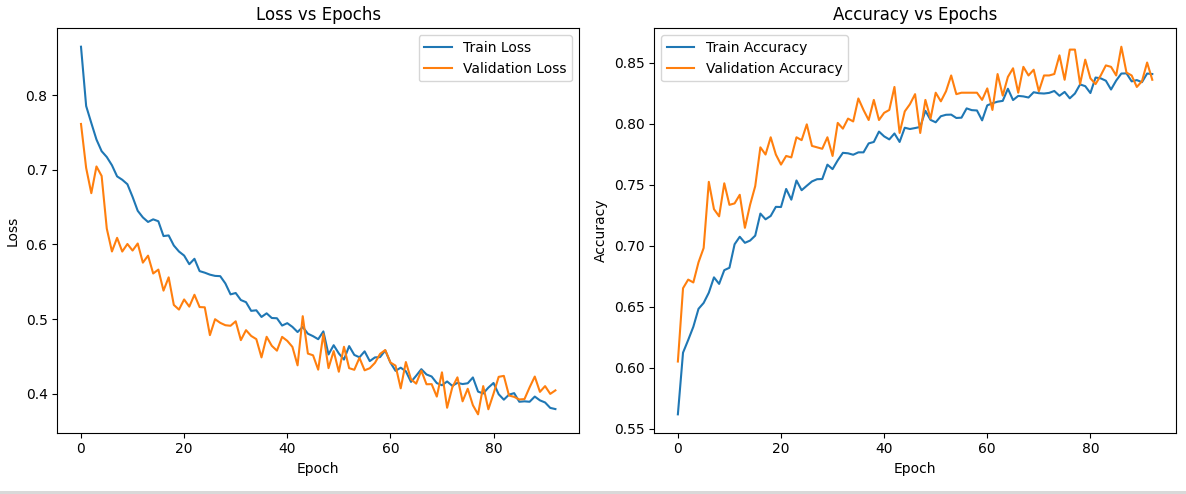